In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices())

import gc
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import Callback
class FreeMemory(Callback):
    def __init__(self, log_freq=None):
        super().__init__()
        self.log_freq = log_freq
    def on_epoch_end(self, epoch, logs=None):
        if self.log_freq and epoch % self.log_freq == 0:
            print(f'epoch {epoch} ended, info: {logs}')
        clear_session()
        gc.collect()

        
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

import numpy as np
train_fourier = np.fft.fft2(train_images)
test_fourier = np.fft.fft2(test_images)

PX_ROWS = 28
PX_COLS = 28
CLASSES_NUM = 10

one_hot_train = tf.one_hot(train_labels, CLASSES_NUM)
one_hot_test = tf.one_hot(test_labels, CLASSES_NUM)

2023-12-14 18:42:29.841903: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 18:42:29.864992: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 18:42:29.865012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 18:42:29.865031: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 18:42:29.869497: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-14 18:42:31.709430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 18:42:31.709545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 18:42:31.709607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
EPOCHS_NUM = 50

from tensorflow.keras.optimizers import SGD, Adam
# OPTIMIZER = lambda: Adam()
OPTIMIZER = lambda: SGD(learning_rate=0.01)#, momentum=0.01)

## complex

In [15]:
from cvnn.layers import ComplexInput, ComplexDense, ComplexConv2D, ComplexMaxPooling2D, ComplexDropout, ComplexFlatten

cvnn_model = tf.keras.Sequential()
cvnn_model.add(ComplexInput(input_shape=((PX_ROWS, PX_COLS, 1))))
cvnn_model.add(ComplexConv2D(filters=16, kernel_size=3, padding='same', activation='cart_relu')) 
cvnn_model.add(ComplexMaxPooling2D(pool_size=2))
cvnn_model.add(ComplexConv2D(filters=64, kernel_size=2, padding='same', activation='cart_relu'))
cvnn_model.add(ComplexMaxPooling2D(pool_size=2))
cvnn_model.add(ComplexFlatten())
cvnn_model.add(ComplexDense(256, activation='cart_sigmoid'))
cvnn_model.add(ComplexDropout(0.5))
cvnn_model.add(ComplexDense(CLASSES_NUM, activation='cart_softmax'))


from cvnn.metrics import ComplexCategoricalAccuracy
from cvnn.losses import ComplexAverageCrossEntropy

cvnn_model.compile(loss=ComplexAverageCrossEntropy(name='categorical_crossentropy'),
              optimizer=OPTIMIZER(),
              metrics=[ComplexCategoricalAccuracy(name='categorical_accuracy')])
cvnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_conv2d_4 (ComplexC  (None, 28, 28, 16)        320       
 onv2D)                                                          
                                                                 
 complex_max_pooling2d_4 (C  (None, 14, 14, 16)        0         
 omplexMaxPooling2D)                                             
                                                                 
 complex_conv2d_5 (ComplexC  (None, 14, 14, 64)        8320      
 onv2D)                                                          
                                                                 
 complex_max_pooling2d_5 (C  (None, 7, 7, 64)          0         
 omplexMaxPooling2D)                                             
                                                                 
 complex_flatten_2 (Complex  (None, 3136)             

In [4]:
cvnn_history = cvnn_model.fit(train_fourier, one_hot_train, validation_data=(test_fourier, one_hot_test), batch_size=128, epochs=EPOCHS_NUM, verbose=0, callbacks=[FreeMemory(10)])
cvnn_model.evaluate(test_fourier, one_hot_test, verbose=2)

2023-12-14 18:42:35.175004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-12-14 18:42:37.080493: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb52c312750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 18:42:37.080510: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-12-14 18:42:37.117425: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch 0 ended, info: {'loss': 0.7187801599502563, 'categorical_accuracy': 0.755383312702179, 'val_loss': 0.47258052229881287, 'val_categorical_accuracy': 0.8246999979019165}
epoch 10 ended, info: {'loss': 0.2907443046569824, 'categorical_accuracy': 0.8956500291824341, 'val_loss': 0.3311520218849182, 'val_categorical_accuracy': 0.8815000057220459}
epoch 20 ended, info: {'loss': 0.22899435460567474, 'categorical_accuracy': 0.9172499775886536, 'val_loss': 0.315605491399765, 'val_categorical_accuracy': 0.8858000040054321}
epoch 30 ended, info: {'loss': 0.18199127912521362, 'categorical_accuracy': 0.934166669845581, 'val_loss': 0.3243441581726074, 'val_categorical_accuracy': 0.885699987411499}
epoch 40 ended, info: {'loss': 0.14589090645313263, 'categorical_accuracy': 0.9486166834831238, 'val_loss': 0.3291902244091034, 'val_categorical_accuracy': 0.8858000040054321}
313/313 - 1s - loss: 0.3510 - categorical_accuracy: 0.8860 - 723ms/epoch - 2ms/step


[0.3510195016860962, 0.8859999775886536]

## real

In [22]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

rvnn_model = tf.keras.Sequential()
rvnn_model.add(Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', input_shape=(PX_ROWS, PX_COLS, 1))) 
rvnn_model.add(MaxPooling2D(pool_size=2))
rvnn_model.add(Conv2D(filters=96, kernel_size=2, padding='same', activation='relu'))
rvnn_model.add(MaxPooling2D(pool_size=2))
rvnn_model.add(Flatten())
rvnn_model.add(Dense(341, activation='sigmoid'))
rvnn_model.add(Dropout(0.5))
rvnn_model.add(Dense(CLASSES_NUM, activation='softmax'))

rvnn_model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER(),
              metrics=['categorical_accuracy'])
rvnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 24)        240       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 24)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 96)        9312      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 96)          0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 4704)              0         
                                                                 
 dense_12 (Dense)            (None, 341)              

In [6]:
rvnn_history = rvnn_model.fit(train_images, one_hot_train, validation_data=(test_images, one_hot_test), batch_size=128, epochs=EPOCHS_NUM, verbose=0, callbacks=[FreeMemory(10)])
rvnn_model.evaluate(test_images, one_hot_test, verbose=2)

epoch 0 ended, info: {'loss': 1.1848269701004028, 'categorical_accuracy': 0.5566166639328003, 'val_loss': 0.7804811596870422, 'val_categorical_accuracy': 0.6995000243186951}
epoch 10 ended, info: {'loss': 0.37726643681526184, 'categorical_accuracy': 0.8597000241279602, 'val_loss': 0.3741413950920105, 'val_categorical_accuracy': 0.8616999983787537}
epoch 20 ended, info: {'loss': 0.30874961614608765, 'categorical_accuracy': 0.8855666518211365, 'val_loss': 0.31738436222076416, 'val_categorical_accuracy': 0.8824999928474426}
epoch 30 ended, info: {'loss': 0.2731177806854248, 'categorical_accuracy': 0.8979833126068115, 'val_loss': 0.2913583815097809, 'val_categorical_accuracy': 0.8924999833106995}
epoch 40 ended, info: {'loss': 0.24153746664524078, 'categorical_accuracy': 0.9102166891098022, 'val_loss': 0.26958343386650085, 'val_categorical_accuracy': 0.8995000123977661}
313/313 - 0s - loss: 0.2698 - categorical_accuracy: 0.8989 - 303ms/epoch - 969us/step


[0.26977288722991943, 0.8988999724388123]

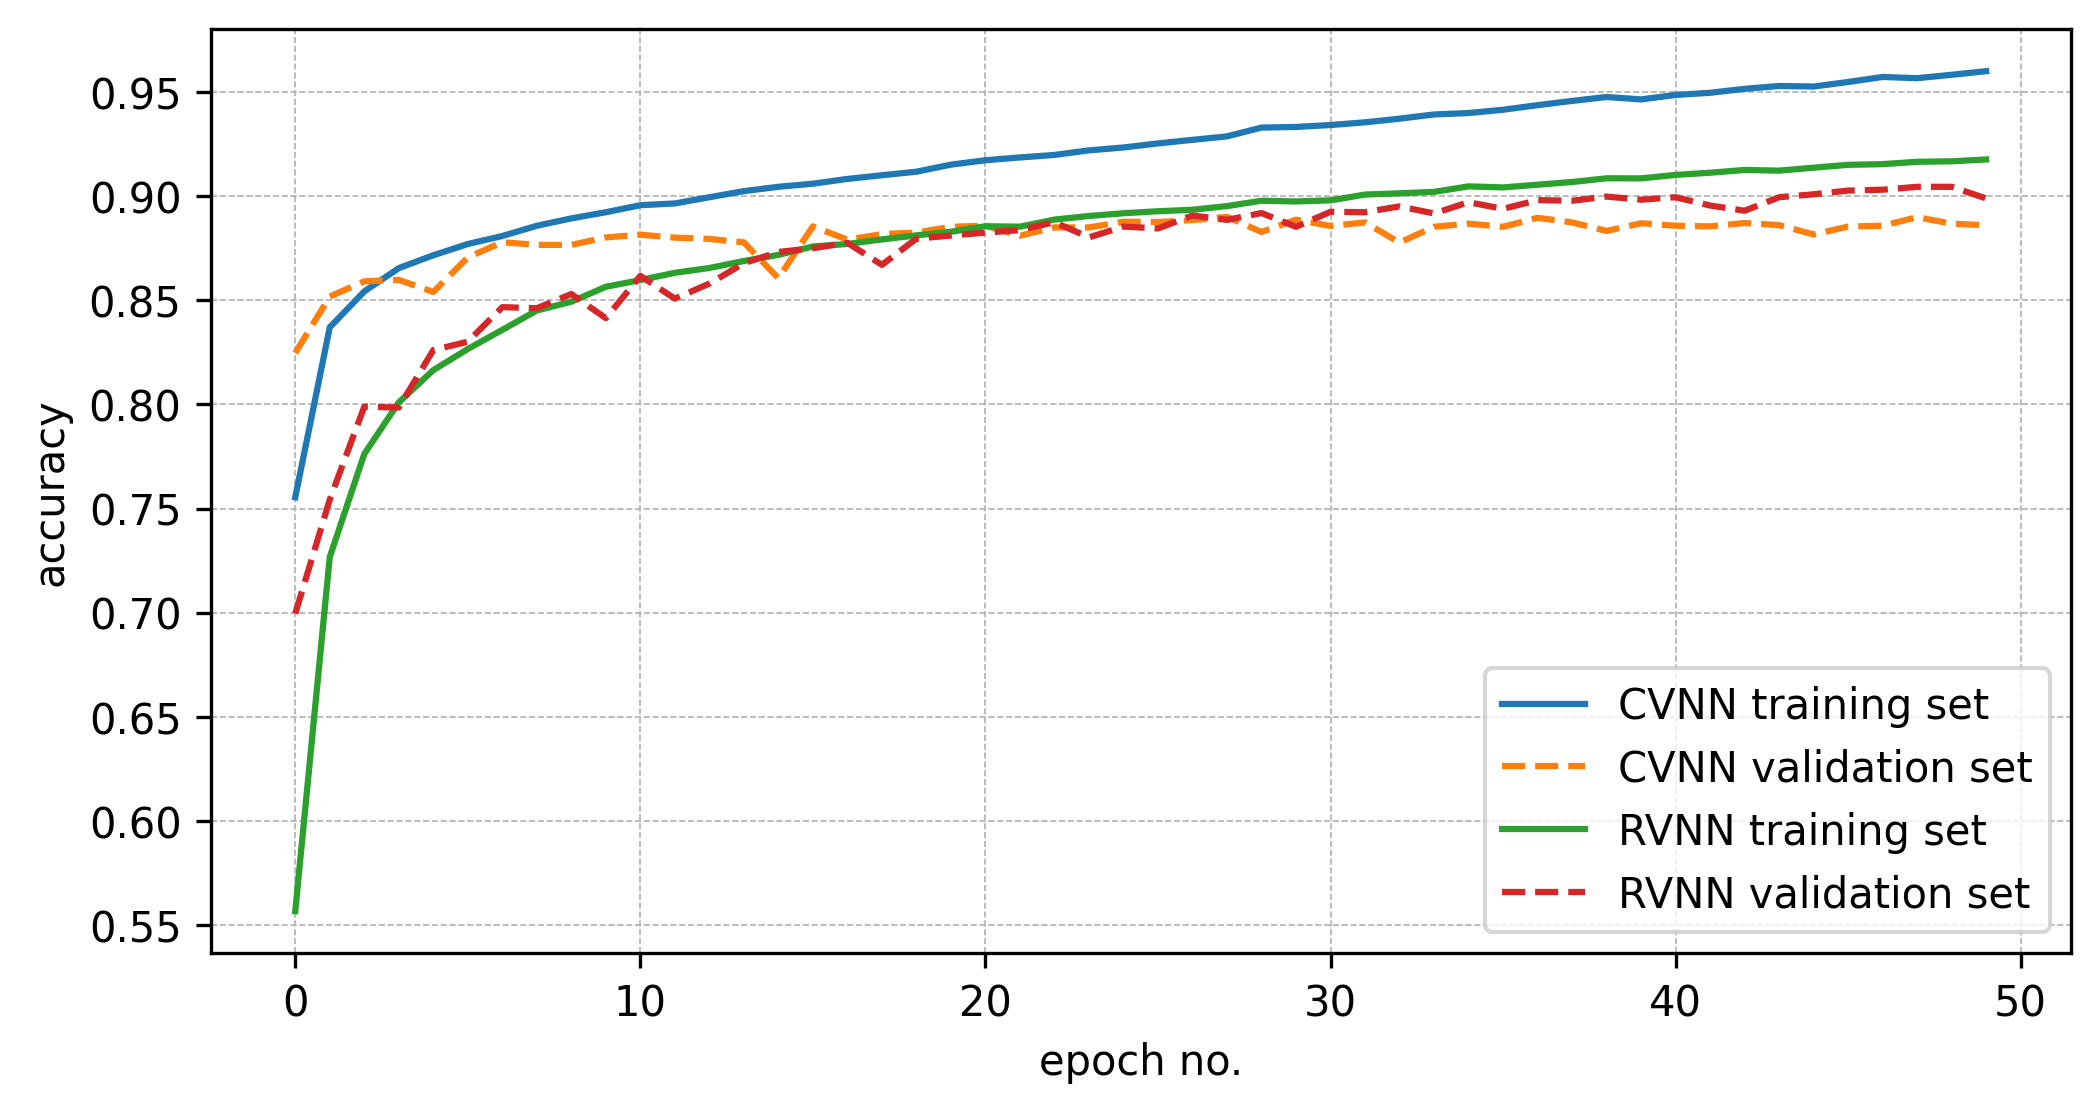

In [12]:
import pandas as pd
def make_dataframe(fit_history):
    df = pd.DataFrame(fit_history.history)
    df.insert(0, 'epoch', fit_history.epoch)
    return df

import matplotlib.pyplot as plt
def plot_accuracy_history_comparision(rvnn_fit_history, cvnn_fit_history):
    
    rvnn_dataframe = make_dataframe(rvnn_fit_history)
    cvnn_dataframe = make_dataframe(cvnn_fit_history)
    
    plt.figure(figsize=(8,4), dpi=300)
    plt.plot(cvnn_dataframe['epoch'], cvnn_dataframe['categorical_accuracy'], label='CVNN training set')
    plt.plot(cvnn_dataframe['epoch'], cvnn_dataframe['val_categorical_accuracy'], linestyle='dashed', label='CVNN validation set')
    plt.plot(rvnn_dataframe['epoch'], rvnn_dataframe['categorical_accuracy'], label='RVNN training set')
    plt.plot(rvnn_dataframe['epoch'], rvnn_dataframe['val_categorical_accuracy'], linestyle='dashed', label='RVNN validation set')
    plt.legend(loc="lower right")
    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.grid(linestyle='--', linewidth=0.4)
    # plt.xlim((-1,11))
    # plt.ylim((0.92,1))
    plt.show()
    
plot_accuracy_history_comparision(rvnn_history, cvnn_history)